<a href="https://colab.research.google.com/github/prerana30/API_Python/blob/main/Sales_Estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install pmdarima
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.display import display
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima

In [ ]:
df = pd.read_csv('KiranaPasal_Data.csv', index_col='Date', parse_dates=True)

In [ ]:
df.info() , df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2081-01-01 to 2082-12-31
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sales               730 non-null    int64  
 1   Festival_Indicator  730 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 17.1 KB


(None,
             Sales  Festival_Indicator
 Date                                 
 2081-01-01  23904                 0.0
 2081-01-02  31138                 0.0
 2081-01-03  19682                 0.0
 2081-01-04  20632                 0.0
 2081-01-05  18692                 0.0)

**Check for Stationarity**

**The SARIMAX model assumes that the time series is stationary. If the data is not stationary, the model may produce unreliable results. Use the Augmented Dickey-Fuller (ADF) test to check for stationarity:**

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(df['Sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -11.71429363286165
p-value: 1.4637535944274574e-21


If the p-value > 0.05, the series is non-stationary. Apply differencing (d and D in SARIMAX) to make it stationary.

####**Tuning Sarimax Parameters**

1. Grid Search

* Very Slow approach

In [ ]:
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

# Split data (80% Train, 20% Test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define parameter ranges (Reduce search space for speed)
p = d = q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

# Function to train and evaluate model
def evaluate_sarimax(order, seasonal_order):
    try:
        model = SARIMAX(train['Sales'].values,
                        exog=train[['Festival_Indicator']].values,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=0)
        return order, seasonal_order, results.aic
    except:
        return order, seasonal_order, np.inf  # Assign high AIC to failed models

# Run grid search in parallel
results = Parallel(n_jobs=-1)(delayed(evaluate_sarimax)(param, seasonal_param)
                               for param in itertools.product(p, d, q)
                               for seasonal_param in seasonal_pdq)

# Find best parameters
best_order, best_seasonal_order, best_aic = min(results, key=lambda x: x[2])

print(f'Best SARIMAX Order: {best_order}')
print(f'Best Seasonal Order: {best_seasonal_order}')
print(f'Best AIC: {best_aic}')


Best SARIMAX Order: (0, 0, 0)
Best Seasonal Order: (2, 2, 2, 12)
Best AIC: 10945.744567735823


* Best SARIMAX Order: (0, 0, 0)
* Best Seasonal Order: (2, 2, 2, 12)
* Best AIC: 10945.744567735823

In [ ]:

# Split data (80% Train, 20% Test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
#2. Automatically find the best SARIMAX parameters
model = auto_arima(train['Sales'],
                   exogenous=train[['Festival_Indicator']],
                   seasonal=True,
                   m=12,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

print(model.summary())

# Re-fit the model without insignificant terms
model = SARIMAX(train['Sales'],
                exog=train[['Festival_Indicator']],
                order=(0, 0, 0),  # Remove AR term
                seasonal_order=(2, 2, 2, 12),  # Remove seasonal AR term
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=11939.727, Time=5.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=11940.360, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=11911.561, Time=0.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=11917.215, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13549.825, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=11910.174, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=11911.170, Time=0.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=11904.941, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=11906.522, Time=0.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=11906.357, Time=0.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=11908.351, Time=1.55 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=11901.063, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=11902.518, Time=1.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=11902.377, Time=0.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=11904.372, Time=2.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[12] intercept   : AIC=11897.764, Time=0.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,0,0)[12] intercept   : AIC=11899.145, Time=2.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,1)[12] intercept   : AIC=11898.993, Time=1.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,0,1)[12] intercept   : AIC=11900.989, Time=2.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[12] intercept   : AIC=11899.004, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=11899.710, Time=0.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=11902.810, Time=0.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[12] intercept   : AIC=11900.987, Time=0.47 sec
 ARIMA(4,0,0)(0,0,0)[12]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(4,0,0)(0,0,0)[12] intercept
Total fit time: 25.153 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -5942.882
Date:                Fri, 28 Feb 2025   AIC                          11897.764
Time:                        07:59:06   BIC                          11923.984
Sample:                    01-01-2081   HQIC                         11907.983
                         - 08-07-2082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
i

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                   SARIMAX Results                                   
Dep. Variable:                         Sales   No. Observations:                  584
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood               -5466.872
Date:                       Fri, 28 Feb 2025   AIC                          10945.745
Time:                               07:59:10   BIC                          10971.438
Sample:                           01-01-2081   HQIC                         10955.797
                                - 08-07-2082                                         
Covariance Type:                         opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Festival_Indicator  2.124e+04    971.123     21.875      0.000    1.93e+04    2.31e+04
ar.S.L12              -0.4629      0.148     -3.120

In [ ]:
# Define SARIMAX model (simple order, will tune later)
model = SARIMAX(train['Sales'],
                exog=train[['Festival_Indicator']],
                order=(0, 0, 0),
                seasonal_order=(2, 2, 2, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
sarimax_model = model.fit(disp=False)

# Summary of the model
sarimax_model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                         Sales   No. Observations:                  584
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood               -5466.872
Date:                       Fri, 28 Feb 2025   AIC                          10945.745
Time:                               08:24:37   BIC                          10971.438
Sample:                           01-01-2081   HQIC                         10955.797
                                - 08-07-2082                                         
Covariance Type:                         opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Festival_Indicator  2.124e+04    971.123     21.875      0.000    1.93e+04    2.31e+04
ar.S.L12              -0.4629      0.148     -3.120      0.002      -0.754      -0.172
ar.S.L24              -0.2353      0.090     -2.604      0.009      -0.412      -0.058
ma.S.L12              -1.1182      0.148     -7.555      0.000      -1.408      -0.828
ma.S.L24               0.1864      0.139      1.346      0.178      -0.085       0.458
sigma2              4.727e+07      0.076    6.2e+08      0.000    4.73e+07    4.73e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.31   Prob(JB):                         0.37
Heteroskedasticity (H):               0.74   Skew:                            -0.14
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.48e+23. Standard errors may be unstable.
"""

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
#Bayesian Optimization (More Efficient than Grid Search)
from skopt import gp_minimize
from skopt.space import Integer
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMAX evaluation function
def sarimax_objective(params):
    p, d, q, P, D, Q = params
    try:
        model = SARIMAX(train['Sales'],
                        exog=train[['Festival_Indicator']],
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=0)
        return results.aic
    except:
        return np.inf  # Assign a high AIC for failed models

# Define search space
search_space = [
    Integer(0, 2, name="p"),
    Integer(0, 2, name="d"),
    Integer(0, 2, name="q"),
    Integer(0, 2, name="P"),
    Integer(0, 2, name="D"),
    Integer(0, 2, name="Q"),
]

# Run Bayesian Optimization
res = gp_minimize(sarimax_objective, search_space, n_calls=20, random_state=42)

best_params = res.x
print(f"Best SARIMAX Order: {(best_params[0], best_params[1], best_params[2])}")
print(f"Best Seasonal Order: {(best_params[3], best_params[4], best_params[5], 12)}")

Best SARIMAX Order: (0, 0, 0)
Best Seasonal Order: (1, 1, 2, 12)


In [ ]:
# Define the SARIMA model
data = df['Sales']
model = sm.tsa.SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 2, 12))

In [ ]:
# Fit the model
sarima_fit = model.fit(disp=0)
# Print summary of the model
print(sarima_fit.summary())

# Make predictions
predictions = sarimax_model.predict(start=test.index[0], end=test.index[-1], exog=test[['Festival_Indicator']], dynamic=False)


                                   SARIMAX Results                                   
Dep. Variable:                         Sales   No. Observations:                  584
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood               -5466.872
Date:                       Fri, 28 Feb 2025   AIC                          10945.745
Time:                               08:25:07   BIC                          10971.438
Sample:                           01-01-2081   HQIC                         10955.797
                                - 08-07-2082                                         
Covariance Type:                         opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Festival_Indicator  2.124e+04    971.123     21.875      0.000    1.93e+04    2.31e+04
ar.S.L12              -0.4629      0.148     -3.120

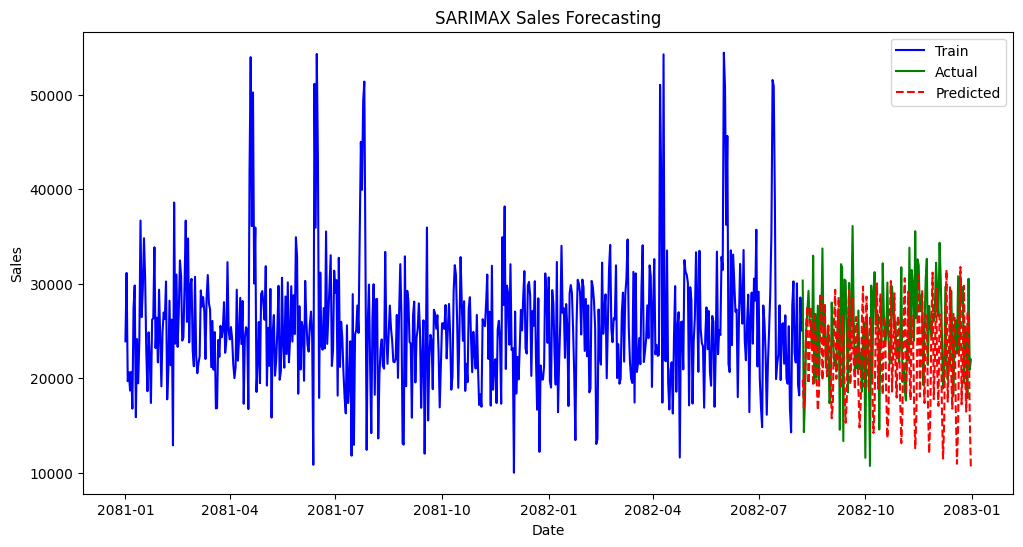

In [ ]:
# Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Train', color='blue')
plt.plot(test.index, test['Sales'], label='Actual', color='green')
plt.plot(test.index, predictions, label='Predicted', color='red', linestyle='dashed')
plt.legend()
plt.title("SARIMAX Sales Forecasting")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [ ]:
# Make predictions
predictions = sarimax_model.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test[['Festival_Indicator']],
    dynamic=False
)

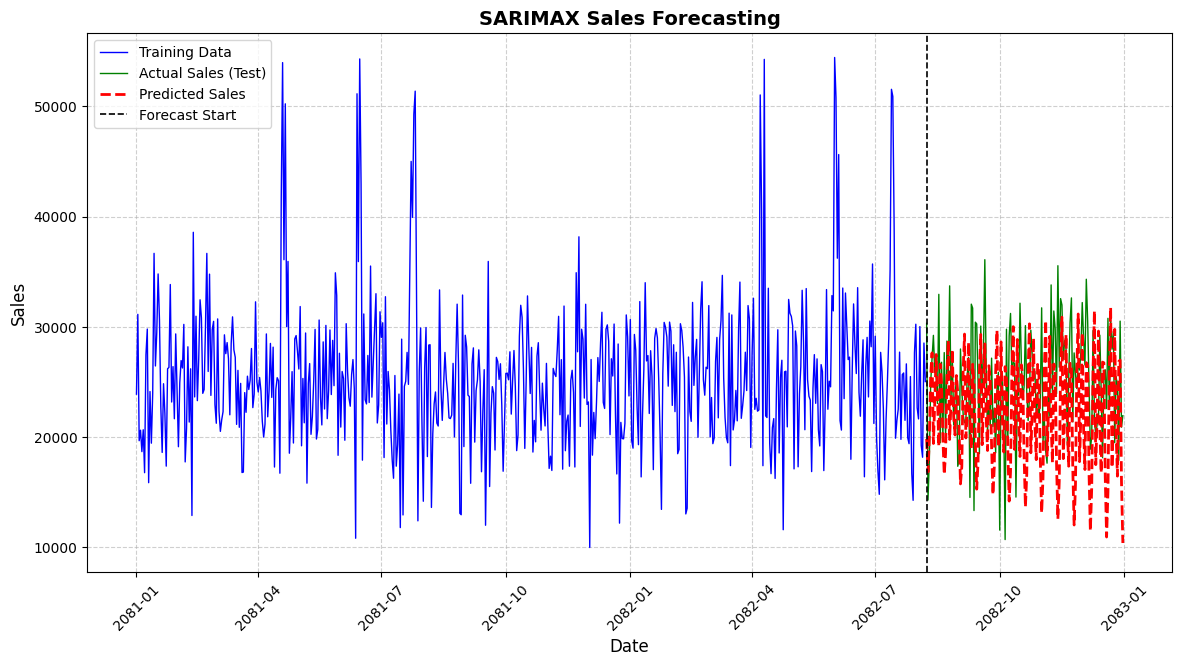

In [ ]:
# Create figure
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train['Sales'], label='Training Data', color='blue', linewidth=1)

# Plot actual test data
plt.plot(test.index, test['Sales'], label='Actual Sales (Test)', color='green', linewidth=1)

# Plot predicted data
plt.plot(test.index, predictions, label='Predicted Sales', color='red', linestyle='dashed', linewidth=2)

# Add vertical line to mark transition from training to testing
plt.axvline(x=test.index[0], color='black', linestyle='--', linewidth=1.2, label="Forecast Start")

# Titles and labels
plt.title("SARIMAX Sales Forecasting", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.legend(loc='upper left', fontsize=10)  # Move legend for clarity
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better visualization

# Show plot
plt.show()

In [ ]:
# Apply smoothing for better visualization
train_smooth = train['Sales'].rolling(window=7).mean()
test_smooth = test['Sales'].rolling(window=7).mean()
pred_smooth = predictions.rolling(window=7).mean()

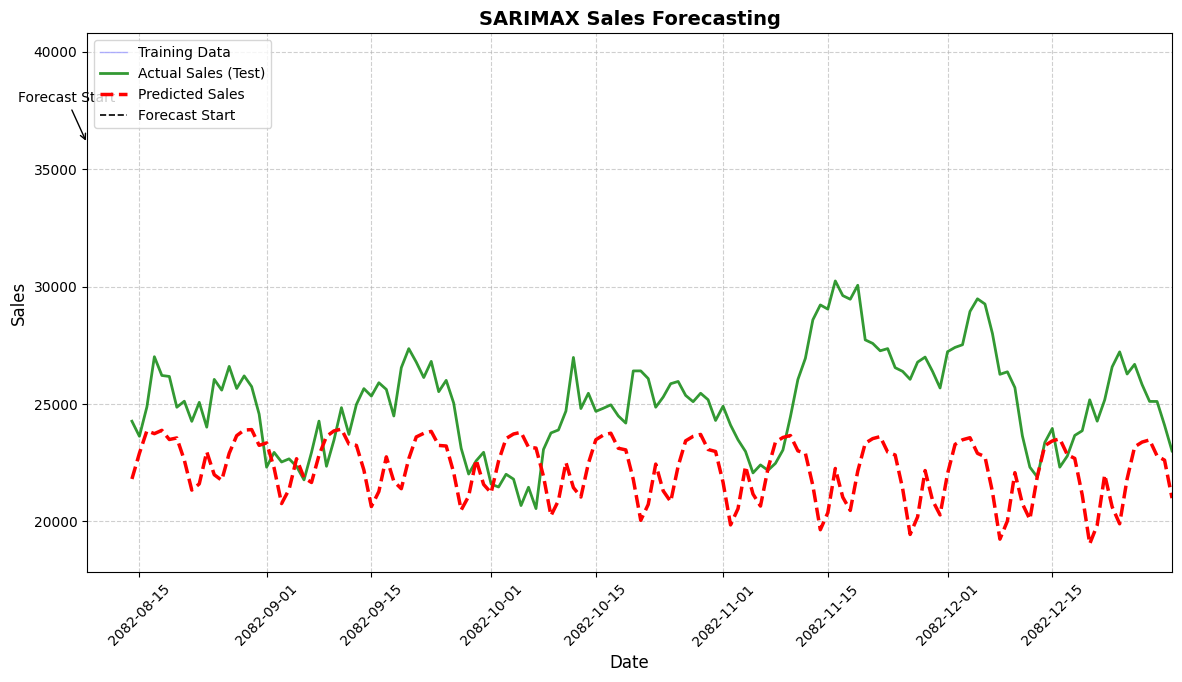

In [ ]:
# Create figure
plt.figure(figsize=(14, 7))

# Plot training data (faded)
plt.plot(train.index, train_smooth, label='Training Data', color='blue', alpha=0.3, linewidth=1)

# Plot actual test data (bold)
plt.plot(test.index, test_smooth, label='Actual Sales (Test)', color='green', alpha=0.8, linewidth=2)

# Plot predicted data (bold & dashed)
plt.plot(test.index, pred_smooth, label='Predicted Sales', color='red', linestyle='dashed', linewidth=2.5)

# Add confidence interval if available
# plt.fill_between(test.index, lower_bound, upper_bound, color='red', alpha=0.2, label='Prediction Interval')

# Add vertical line to mark transition from training to testing
plt.axvline(x=test.index[0], color='black', linestyle='--', linewidth=1.2, label="Forecast Start")

# Annotate forecast start
plt.annotate("Forecast Start", xy=(test.index[0], test['Sales'].max()),
             xytext=(-50, 30), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'))

# Titles and labels
plt.title("SARIMAX Sales Forecasting", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.legend(loc='upper left', fontsize=10)  # Move legend for clarity
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better visualization

# Zoom in on forecast period
plt.xlim(test.index[0], test.index[-1])

# Show plot
plt.show()

**Address Insignificant Coefficients**

The current model has insignificant coefficients for ar.L1 and ar.S.L12 (p-values > 0.05). This suggests that these terms may not be necessary.

* Remove the insignificant terms by setting their orders to 0.
* Re-fit the model with updated orders.

##**New Seasonal Data (including Festival)**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [4]:
file_path = "HisabKitab_data.csv"
df = pd.read_csv(file_path)

In [5]:
#Convert Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Exploratory Data Analysis

In [6]:
print("Dataset Overview:")
print(f"Time Range: {df.index.min()} to {df.index.max()}")
print(f"Number of Observations: {len(df)}")
print(f"Festivals present: {df['Festival'].unique()}")
print(f"Seasons present: {df['Season'].unique()}")

Dataset Overview:
Time Range: 2021-01-01 00:00:00 to 2023-09-28 00:00:00
Number of Observations: 1103
Festivals present: [0 1]
Seasons present: [0 1]


**Visualizations**

<Figure size 1400x700 with 0 Axes>

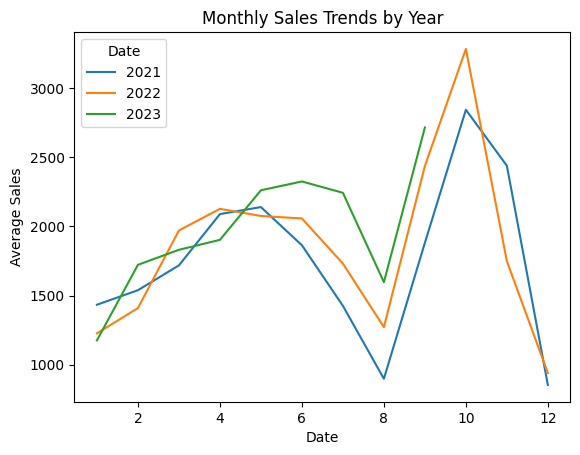

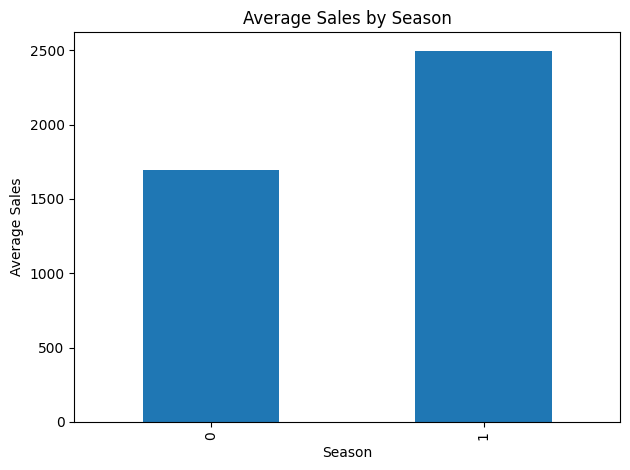

In [16]:
plt.figure(figsize=(14, 7))
#plt.subplot(2, 1, 1)
df.groupby([df.index.year, df.index.month])['Sales'].mean().unstack().T.plot(
    title='Monthly Sales Trends by Year')
plt.ylabel('Average Sales')
plt.show()

#plt.subplot(2, 1, 2)
df.groupby('Season')['Sales'].mean().plot(kind='bar',
    title='Average Sales by Season')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.savefig('seasonal_patterns.png')
plt.show()

### **Festival impact analysis**

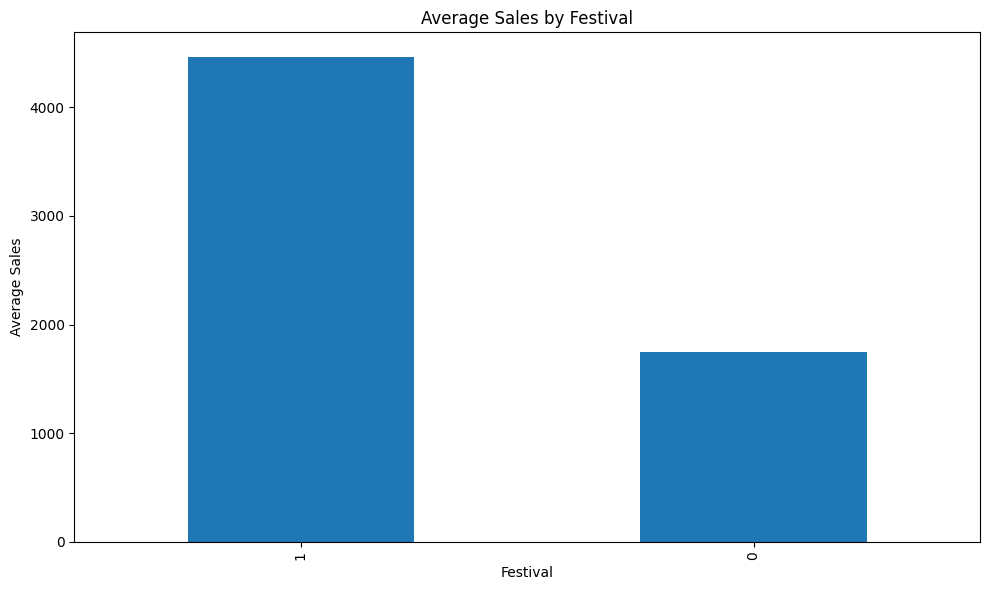

In [18]:
plt.figure(figsize=(10, 6))
festival_impact = df.groupby('Festival')['Sales'].mean().sort_values(ascending=False)
festival_impact.plot(kind='bar', title='Average Sales by Festival')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.savefig('festival_impact.png')
plt.show()
#plt.close()

##**Enhanced Feature Engineering**

In [20]:
# 1. Improved time-based features
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Quarter'] = df.index.quarter
df['DayOfWeek'] = df.index.dayofweek
df['WeekOfYear'] = df.index.isocalendar().week

# 2. Advanced lag features with different timeframes
df['Sales_Lag1'] = df['Sales'].shift(1)
df['Sales_Lag7'] = df['Sales'].shift(7)
df['Sales_Lag30'] = df['Sales'].shift(30)
df['Sales_Lag365'] = df['Sales'].shift(365)  # Annual seasonal lag

# 3. Multiple rolling windows for better capturing trends
df['Rolling_Avg_7'] = df['Sales'].rolling(window=7).mean()
df['Rolling_Avg_30'] = df['Sales'].rolling(window=30).mean()
df['Rolling_Avg_90'] = df['Sales'].rolling(window=90).mean()

# 4. Volatility features
df['Sales_Volatility_7'] = df['Sales'].rolling(window=7).std()
df['Sales_Volatility_30'] = df['Sales'].rolling(window=30).std()

# 5. Festival proximity feature (how close are we to a festival?)
if 'Festival' in df.columns:
    # Convert to numeric first
    df['Festival'] = df['Festival'].astype('category').cat.codes

    # Create rolling window features to capture upcoming festivals
    df['Festival_Coming'] = df['Festival'].rolling(window=7, min_periods=1).max()
    df['Festival_Just_Passed'] = df['Festival'].shift(-7).rolling(window=7, min_periods=1).max()

# 6. Encode categorical variables
if 'Season' in df.columns:
    df['Season'] = df['Season'].astype('category').cat.codes

# 7. Normalize numerical features
scaler = MinMaxScaler()
numerical_cols = ['Average']
if set(numerical_cols).issubset(df.columns):
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [21]:
# Fill NaN values created by lag features
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)  # Additional fill for any remaining NaNs

# Define features to use in the model
exog_features = [
    'Average', 'Festival', 'Season',
    'Month', 'Quarter',
    'Sales_Lag1', 'Sales_Lag7', 'Sales_Lag30', 'Sales_Lag365',
    'Rolling_Avg_7', 'Rolling_Avg_30', 'Rolling_Avg_90',
    'Sales_Volatility_7', 'Sales_Volatility_30',
    'Festival_Coming', 'Festival_Just_Passed'
]

In [22]:
# Ensure all features exist in the dataframe
exog_features = [f for f in exog_features if f in df.columns]

target = 'Sales'

# Cross-validation for time series (more robust than a single train-test split)
tscv = TimeSeriesSplit(n_splits=3)
cv_results = []

# Train-test split for final evaluation
train = df[df.index.year < 2023]  # Training: Before 2023
test = df[df.index.year == 2023]  # Testing: 2023

print("\nPerforming hyperparameter search with cross-validation...")


Performing hyperparameter search with cross-validation...


In [23]:
# Grid search for optimal parameters
best_score = float('inf')
best_config = None
best_model = None

# Define parameter grid
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
s_values = [12]  # Monthly seasonality

# For production use, use the full grid search below. For demonstration, we'll use auto_arima
'''
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in s_values:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, s)

                            try:
                                # Use TimeSeriesSplit for cross-validation
                                cv_errors = []
                                for train_idx, test_idx in tscv.split(train):
                                    cv_train = train.iloc[train_idx]
                                    cv_test = train.iloc[test_idx]

                                    cv_train_exog = cv_train[exog_features].fillna(0)
                                    cv_test_exog = cv_test[exog_features].fillna(0)

                                    model = SARIMAX(
                                        cv_train[target],
                                        exog=cv_train_exog,
                                        order=order,
                                        seasonal_order=seasonal_order
                                    ).fit(disp=False)

                                    preds = model.forecast(steps=len(cv_test), exog=cv_test_exog)
                                    error = mean_squared_error(cv_test[target], preds)
                                    cv_errors.append(error)

                                avg_error = np.mean(cv_errors)
                                if avg_error < best_score:
                                    best_score = avg_error
                                    best_config = (order, seasonal_order)
                                    print(f"New best config: {best_config} with MSE: {best_score:.2f}")
                            except:
                                continue
'''

'\nfor p in p_values:\n    for d in d_values:\n        for q in q_values:\n            for P in P_values:\n                for D in D_values:\n                    for Q in Q_values:\n                        for s in s_values:\n                            order = (p, d, q)\n                            seasonal_order = (P, D, Q, s)\n                            \n                            try:\n                                # Use TimeSeriesSplit for cross-validation\n                                cv_errors = []\n                                for train_idx, test_idx in tscv.split(train):\n                                    cv_train = train.iloc[train_idx]\n                                    cv_test = train.iloc[test_idx]\n                                    \n                                    cv_train_exog = cv_train[exog_features].fillna(0)\n                                    cv_test_exog = cv_test[exog_features].fillna(0)\n                                    \n              

In [24]:
# For demonstration purposes, we'll use auto_arima which is faster
print("Running auto_arima to find optimal parameters...")
train_exog = train[exog_features].fillna(0)

auto_model = auto_arima(
    train[target],
    exogenous=train_exog,
    seasonal=True,
    m=12,  # Monthly seasonality
    trace=True,
    suppress_warnings=True,
    stepwise=True,
    error_action='ignore',
    max_order=None,
    d=None,       # Let the algorithm determine d
    D=None,       # Let the algorithm determine D
    start_p=0,
    start_q=0,
    start_P=0,
    start_Q=0,
    max_p=3,
    max_q=3,
    max_P=2,
    max_Q=2,
    information_criterion='aic'
)

best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
best_config = (best_order, best_seasonal_order)
print(f"Best configuration: {best_config}")

Running auto_arima to find optimal parameters...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=13844.925, Time=0.17 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=13626.896, Time=1.99 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=13702.936, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=15084.468, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=13624.972, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=13626.909, Time=0.37 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=13628.895, Time=1.53 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=13572.503, Time=0.10 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=13574.409, Time=0.77 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=13574.424, Time=0.50 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=13576.408, Time=1.55 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=13549.905, Time=0.17 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=13551.247, Time=1.00 sec
 ARIMA(3,0,0)(0,0,1)[12]

## **Train final model with best parameters**

In [33]:
print("Training final model with best parameters...")
train_exog = train[exog_features].fillna(0)
test_exog = test[exog_features].fillna(0)

final_model = SARIMAX(
    train[target],
    exog=train_exog,
    order=best_order,
    seasonal_order=best_seasonal_order
).fit(disp=False)

Training final model with best parameters...


In [34]:
# Predict Sales for 2023
print("Generating predictions and evaluating model...")
test_predictions = final_model.forecast(steps=len(test), exog=test_exog)

# Avoid NaN values
test_predictions = np.nan_to_num(test_predictions, nan=0.0)

# Evaluate model performance
test = test.copy()
test.loc[:, 'Predicted_Sales'] = test_predictions

mae = mean_absolute_error(test[target], test['Predicted_Sales'])
rmse = np.sqrt(mean_squared_error(test[target], test['Predicted_Sales']))
mape = mean_absolute_percentage_error(test[target], test['Predicted_Sales']) * 100

print("\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Generating predictions and evaluating model...

Model Performance:
Mean Absolute Error (MAE): 513.14
Root Mean Squared Error (RMSE): 653.71
Mean Absolute Percentage Error (MAPE): 31.65%


## **Feature importance analysis**


Feature Importance Analysis:
                                        SARIMAX Results                                        
Dep. Variable:                                   Sales   No. Observations:                  834
Model:             SARIMAX(3, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood               -6520.528
Date:                                 Sat, 08 Mar 2025   AIC                          13091.057
Time:                                         15:25:39   BIC                          13209.212
Sample:                                              0   HQIC                         13136.357
                                                 - 834                                         
Covariance Type:                                   opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Average                5

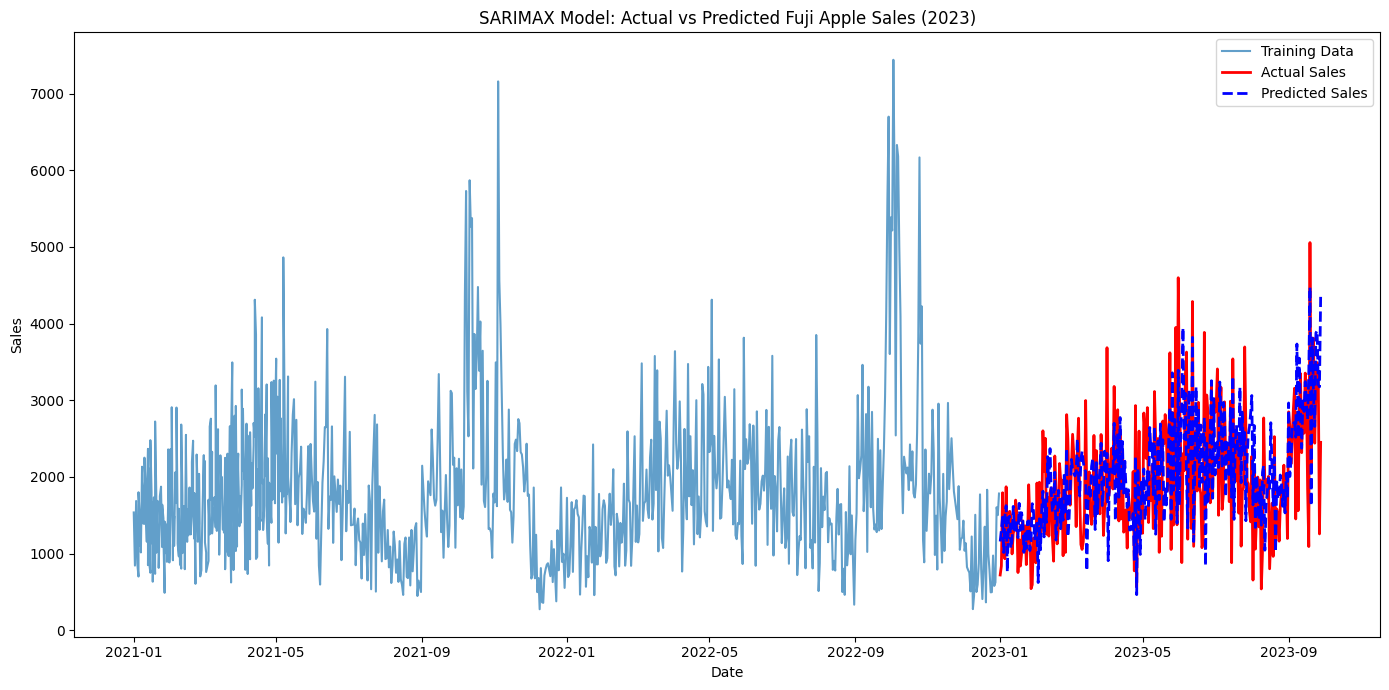

In [41]:
print("\nFeature Importance Analysis:")
try:
    # Check coefficient significance for each feature
    results = final_model.summary()
    print(results)
except:
    print("Could not generate detailed feature importance.")

# Plot actual vs predicted sales
plt.figure(figsize=(14, 7))
plt.plot(train.index, train[target], label="Training Data", alpha=0.7)
plt.plot(test.index, test[target], label="Actual Sales", color='red', linewidth=2)
plt.plot(test.index, test['Predicted_Sales'], label="Predicted Sales",
         linestyle='dashed', color='blue', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.title("SARIMAX Model: Actual vs Predicted Fuji Apple Sales (2023)")
plt.tight_layout()
plt.savefig('model_performance.png')
plt.show()

## **Create future exogenous features**


Generating forecast for 2024...

Sales Forecast for 2024:
            Predicted_Sales
Date                       
2024-01-31      1237.077353
2024-02-29      1075.457486
2024-03-31      1457.260208
2024-04-30      1501.593069
2024-05-31      1910.026370
2024-06-30      2308.743048
2024-07-31      2132.587037
2024-08-31      1745.878185
2024-09-30      2760.665250
2024-10-31      2551.595414
2024-11-30      2543.297848
2024-12-31      1588.818523


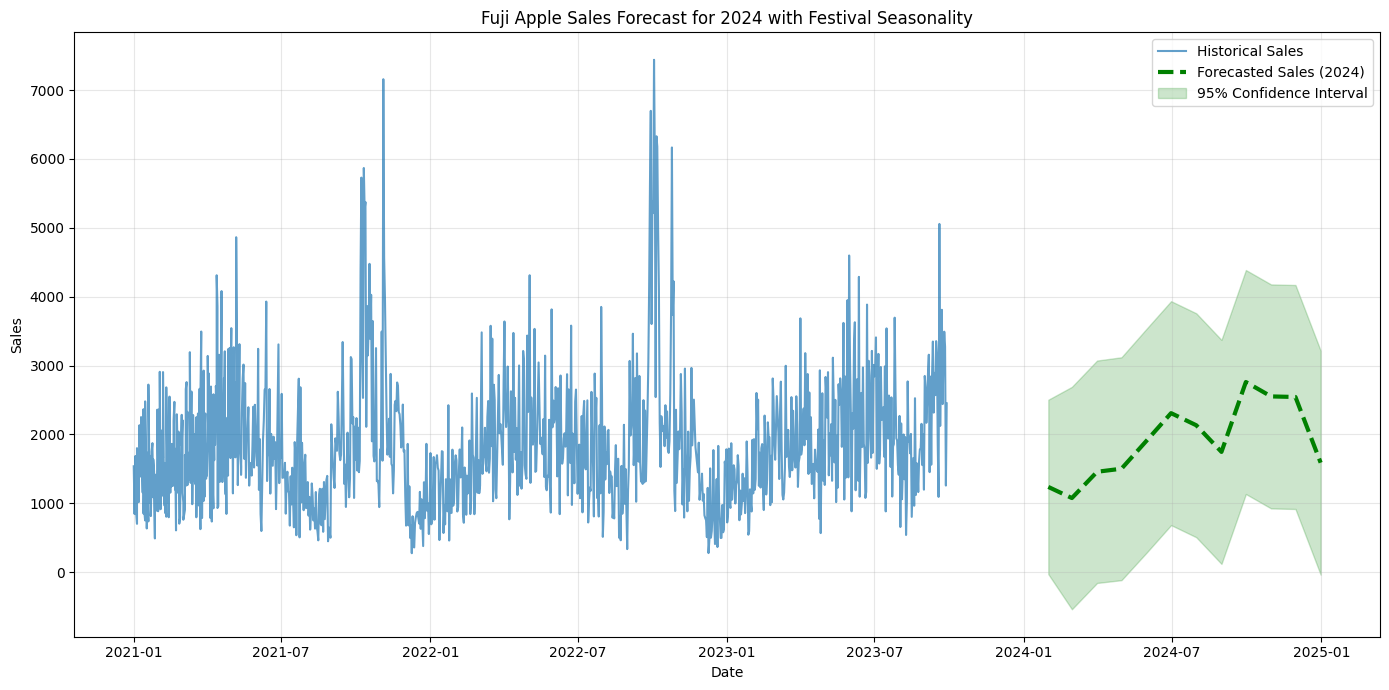

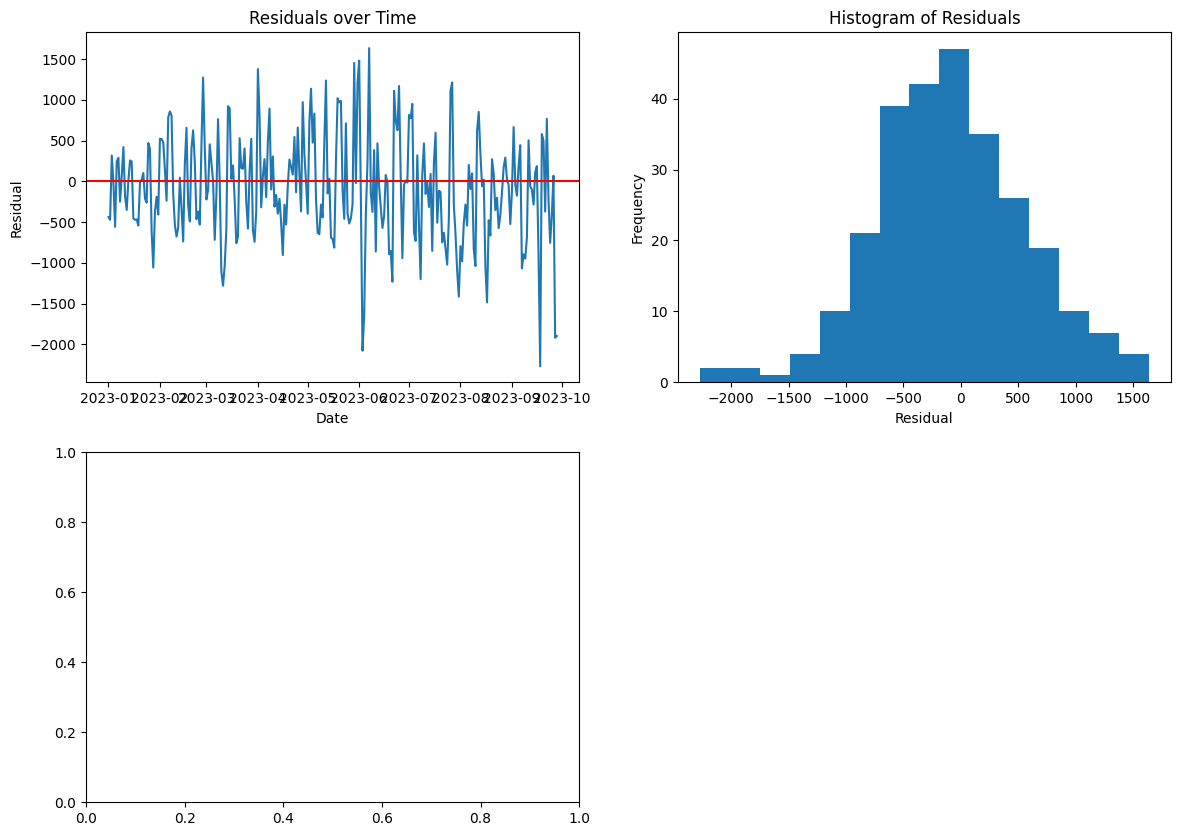

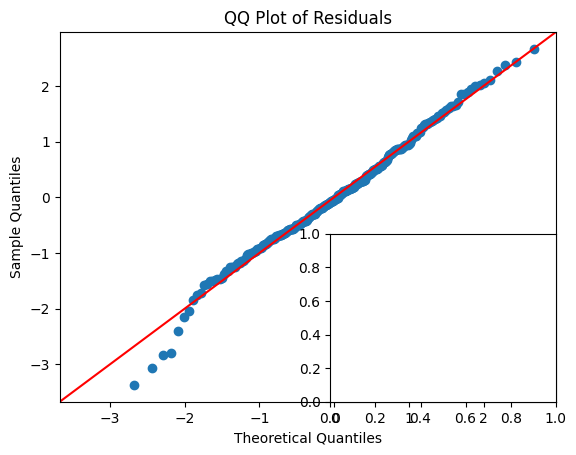

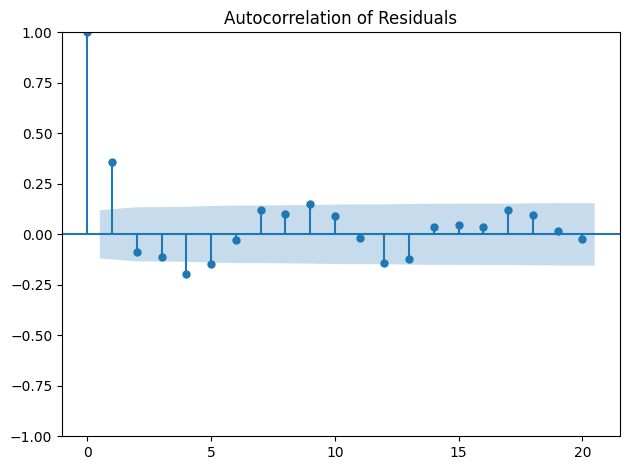

In [47]:
# Generate forecast for 2024
print("\nGenerating forecast for 2024...")
future_dates = pd.date_range(start="2024-01-01", periods=12, freq='M')
future_data = pd.DataFrame(index=future_dates)

future_data['Month'] = future_data.index.month
future_data['Quarter'] = future_data.index.quarter

# Use historical patterns for seasonal features
for feature in exog_features:
    if feature == 'Month' or feature == 'Quarter' or feature == 'Year':
        continue  # Already created above

    if feature == 'Average':
        # Use monthly averages from historical data
        monthly_avgs = df.groupby(df.index.month)['Average'].mean()
        future_data['Average'] = future_data.index.month.map(monthly_avgs)

    elif feature == 'Festival' or feature == 'Festival_Coming' or feature == 'Festival_Just_Passed':
        # Use previous year's festival patterns
        if df.index.year.max() >= 2023:
            last_year_pattern = df[df.index.year == 2023].groupby(df[df.index.year == 2023].index.month)[feature].first().reset_index()  # Reset index
            # Map using month as index for matching
            future_data[feature] = future_data.index.month.map(last_year_pattern.set_index('Date')[feature])
        else:
            # If 2023 data not available, use the latest year
            latest_year = df.index.year.max()
            last_year_pattern = df[df.index.year == latest_year].groupby(df[df.index.year == latest_year].index.month)[feature].first().reset_index()  # Reset index
            # Map using month as index for matching
            future_data[feature] = future_data.index.month.map(last_year_pattern.set_index('Date')[feature])
    elif feature == 'Season':
        # Map months to seasons
        season_map = {
            1: 0,  # Winter
            2: 0,
            3: 1,  # Spring
            4: 1,
            5: 1,
            6: 2,  # Summer
            7: 2,
            8: 2,
            9: 3,  # Fall
            10: 3,
            11: 3,
            12: 0   # Winter
        }
        future_data['Season'] = future_data.index.month.map(season_map)

    elif 'Lag' in feature or 'Rolling' in feature or 'Volatility' in feature:
        # For lag and rolling features, use monthly averages
        if df.index.year.max() >= 2023:
            monthly_pattern = df[df.index.year == 2023].groupby(df[df.index.year == 2023].index.month)[target].mean()
            future_data[feature] = future_data.index.month.map(monthly_pattern)
        else:
            latest_year = df.index.year.max()
            monthly_pattern = df[df.index.year == latest_year].groupby(df[df.index.year == latest_year].index.month)[target].mean()
            future_data[feature] = future_data.index.month.map(monthly_pattern)

    else:
        # For other features, use the historical average for that month
        monthly_avgs = df.groupby(df.index.month)[feature].mean()
        future_data[feature] = future_data.index.month.map(monthly_avgs)

# Fill any NaNs in the future data
future_data.fillna(method='ffill', inplace=True)
future_data.fillna(method='bfill', inplace=True)

# Ensure all exogenous features are in future_data
for feature in exog_features:
    if feature not in future_data.columns:
        # Use the mean value if feature doesn't exist
        future_data[feature] = df[feature].mean()

future_exog = future_data[exog_features]

# Predict sales for 2024
future_forecast = final_model.forecast(steps=12, exog=future_exog)

# Handle NaN values in forecast
future_forecast = np.nan_to_num(future_forecast, nan=0.0)

# Create DataFrame for forecasted sales
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Sales': future_forecast})
forecast_df.set_index('Date', inplace=True)

# Display forecast
print("\nSales Forecast for 2024:")
print(forecast_df)

# Plot historical and future sales
plt.figure(figsize=(14, 7))
plt.plot(df.index, df[target], label="Historical Sales", alpha=0.7)
plt.plot(forecast_df.index, forecast_df['Predicted_Sales'],
         label="Forecasted Sales (2024)", linestyle='dashed', linewidth=3, color='green')

# Add confidence intervals
try:
    forecast_res = final_model.get_forecast(steps=12, exog=future_exog)
    conf_int = forecast_res.conf_int()
    plt.fill_between(forecast_df.index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='green', alpha=0.2, label="95% Confidence Interval")
except:
    print("Could not generate confidence intervals.")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.title("Fuji Apple Sales Forecast for 2024 with Festival Seasonality")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('future_forecast.png')
plt.show()

# Calculate residual diagnostics
residuals = test[target] - test['Predicted_Sales']

plt.figure(figsize=(14, 10))

# Residual plot
plt.subplot(2, 2, 1)
plt.plot(test.index, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals over Time')
plt.xlabel('Date')
plt.ylabel('Residual')

# Histogram of residuals
plt.subplot(2, 2, 2)
plt.hist(residuals, bins=15)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

# QQ plot of residuals
plt.subplot(2, 2, 3)
sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ Plot of Residuals')

# ACF of residuals
plt.subplot(2, 2, 4)
sm.graphics.tsa.plot_acf(residuals.dropna(), lags=20)
plt.title('Autocorrelation of Residuals')

plt.tight_layout()
plt.savefig('residual_diagnostics.png')
plt.show()

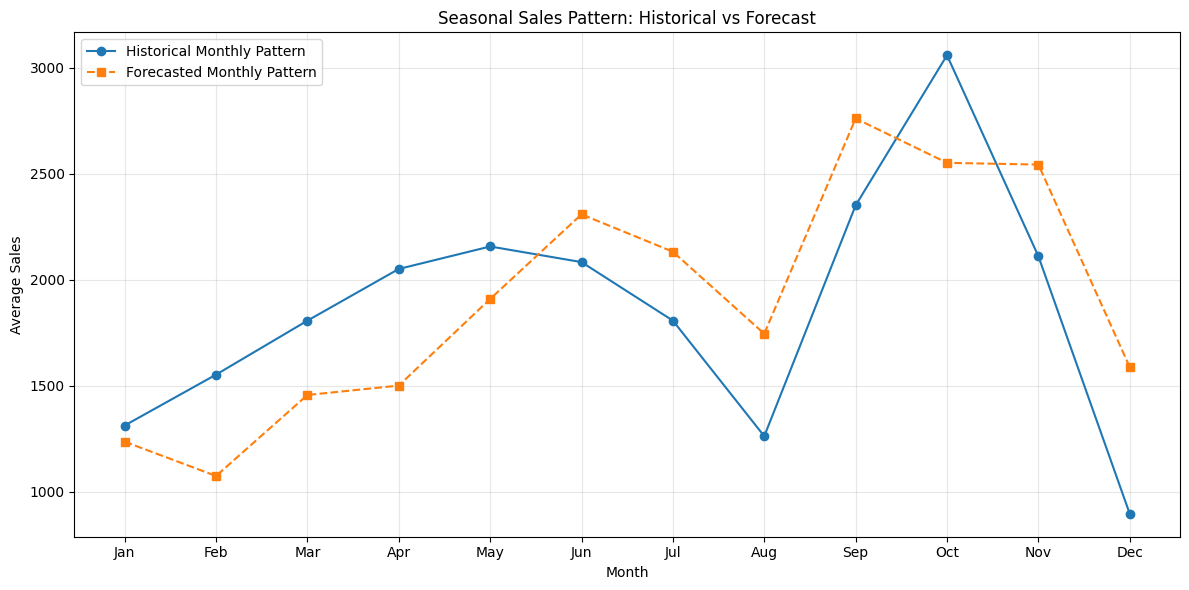

In [48]:
# Monthly seasonal pattern visualization
monthly_sales = df.groupby(df.index.month)[target].mean()
monthly_forecast = forecast_df.groupby(forecast_df.index.month)['Predicted_Sales'].mean()

plt.figure(figsize=(12, 6))
monthly_sales.plot(label='Historical Monthly Pattern', marker='o')
monthly_forecast.plot(label='Forecasted Monthly Pattern', marker='s', linestyle='--')
plt.title('Seasonal Sales Pattern: Historical vs Forecast')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('seasonal_patterns_comparison.png')
plt.show()

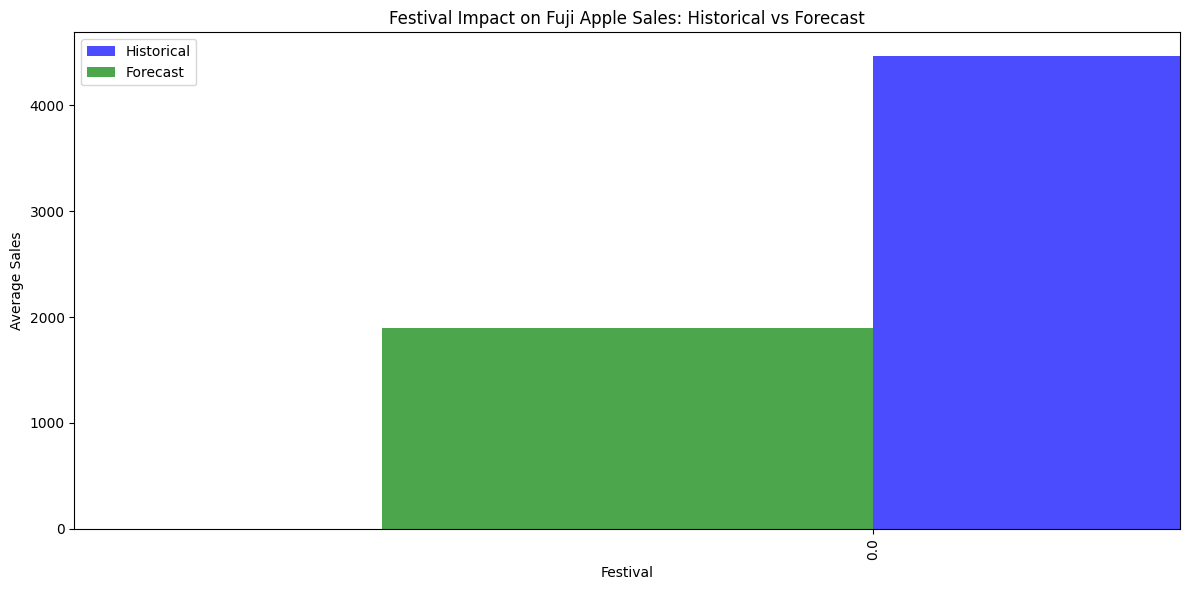

In [49]:
# Festival impact on forecasted sales
if 'Festival' in exog_features:
    plt.figure(figsize=(12, 6))
    # Historical festival impact
    festival_sales = df.groupby('Festival')[target].mean().sort_values(ascending=False)

    # Forecasted festival impact
    future_data['Predicted_Sales'] = future_forecast
    festival_forecast = future_data.groupby('Festival')['Predicted_Sales'].mean().sort_values(ascending=False)

    # Plotting
    festival_sales.plot(kind='bar', position=0, width=0.4, color='blue', alpha=0.7, label='Historical')
    festival_forecast.plot(kind='bar', position=1, width=0.4, color='green', alpha=0.7, label='Forecast')

    plt.title('Festival Impact on Fuji Apple Sales: Historical vs Forecast')
    plt.xlabel('Festival')
    plt.ylabel('Average Sales')
    plt.legend()
    plt.tight_layout()
    plt.savefig('festival_impact_comparison.png')
    plt.show()

###**Save the Model and result**

In [ ]:
import pickle
with open('fuji_apple_sales_model.pkl', 'wb') as f:
    pickle.dump({
        'model': final_model,
        'exog_features': exog_features,
        'best_order': best_order,
        'best_seasonal_order': best_seasonal_order,
        'scaler': scaler,
        'test_metrics': {
            'mae': mae,
            'rmse': rmse,
            'mape': mape
        },
        'forecast_2024': forecast_df
    }, f)

print("\nModel saved as 'fuji_apple_sales_model.pkl'")